In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
fid = drive.ListFile({'q':"title='final_BTSC.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('final_BTSC.zip')
f.keys()
!unzip final_BTSC.zip

Streaming output truncated to the last 5000 lines.
  inflating: final_BTSC/train/00037/1000000000000000000000036.jpg  
  inflating: final_BTSC/train/00037/1000000000000000000000039.jpg  
  inflating: final_BTSC/train/00037/1000000000000000000000044.jpg  
  inflating: final_BTSC/train/00037/1000000000000000000000049.jpg  
  inflating: final_BTSC/train/00037/1000000000000000000000052.jpg  
  inflating: final_BTSC/train/00037/1000000000000000000000084.jpg  
  inflating: final_BTSC/train/00037/100000000000000000000013.jpg  
  inflating: final_BTSC/train/00037/100000000000000000000018.jpg  
  inflating: final_BTSC/train/00037/100000000000000000000022.jpg  
  inflating: final_BTSC/train/00037/100000000000000000000028.jpg  
  inflating: final_BTSC/train/00037/100000000000000000000031.jpg  
  inflating: final_BTSC/train/00037/100000000000000000000040.jpg  
  inflating: final_BTSC/train/00037/100000000000000000000045.jpg  
  inflating: final_BTSC/train/00037/100000000000000000000049.jpg  
  inf

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import numpy as np
from tensorflow import keras

import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

print(tf.__version__)

2.14.0


In [ ]:
dataset = '/content/final_BTSC/train'

test_dir ='/content/final_BTSC/test'

BATCH_SIZE = 32
IMG_SIZE = (96, 96)


In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(dataset,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE,
                                                                 validation_split=.20,
                                                                 subset='training',
                                                                 seed=66)
validation_dataset = tf.keras.utils.image_dataset_from_directory(dataset,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE,
                                                                 validation_split=.20,
                                                                 subset='validation',
                                                                 seed=66)
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                shuffle=True,
                                                                batch_size=BATCH_SIZE,
                                                                image_size=IMG_SIZE)

Found 12400 files belonging to 62 classes.
Using 9920 files for training.
Found 12400 files belonging to 62 classes.
Using 2480 files for validation.
Found 2576 files belonging to 62 classes.


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomContrast(factor=0.1),
        layers.RandomBrightness(factor=0.1),

        layers.RandomZoom(height_factor=0.1, width_factor=0.1),

        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),  # Randomly translate images

    ]
)


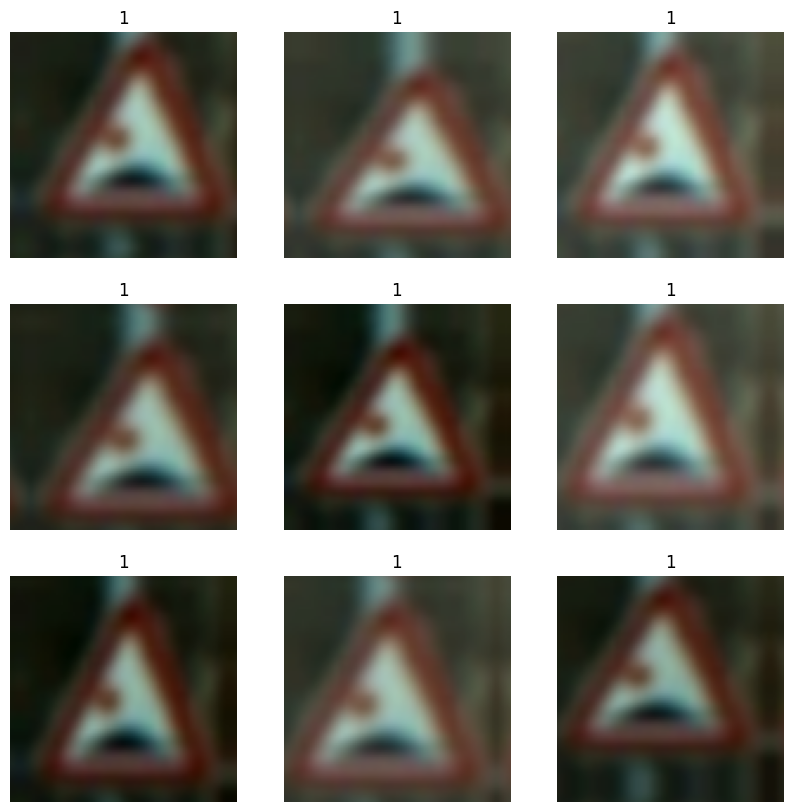

In [ ]:
import numpy as np

for images, labels in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

In [ ]:
base_model = keras.applications.DenseNet201 (
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(96, 96, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.


74836368/74836368 [==============================] - 1s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 102, 102, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 48, 48, 64)           9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 48, 48, 64)           256       ['conv1/conv[0][0]']

In [ ]:
nb_classes = 62
inputs = keras.Input(shape=(96, 96, 3))
x = data_augmentation(inputs)  # Apply random data augmentation
# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
x = keras.layers.Dense(512, activation="relu")(x)
outputs = Dense(nb_classes, activation="softmax")(x)
#outputs = keras.layers.Dense(13)(x)
model = keras.Model(inputs, outputs)

modelF = model

In [ ]:
callback=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)

In [ ]:
model.compile(optimizer='adam' , loss='sparse_categorical_crossentropy',metrics =['accuracy'])

In [ ]:
epochs = 100
history = model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset,callbacks=[callback])

Epoch 1/100
310/310 [==============================] - 48s 77ms/step - loss: 1.2913 - accuracy: 0.6366 - val_loss: 0.5125 - val_accuracy: 0.8375
Epoch 2/100
310/310 [==============================] - 19s 60ms/step - loss: 0.4893 - accuracy: 0.8428 - val_loss: 0.3179 - val_accuracy: 0.8940
Epoch 3/100
310/310 [==============================] - 19s 62ms/step - loss: 0.3693 - accuracy: 0.8789 - val_loss: 0.3099 - val_accuracy: 0.9032
Epoch 4/100
310/310 [==============================] - 21s 68ms/step - loss: 0.3204 - accuracy: 0.8925 - val_loss: 0.2324 - val_accuracy: 0.9242
Epoch 5/100
310/310 [==============================] - 19s 61ms/step - loss: 0.2757 - accuracy: 0.9085 - val_loss: 0.1989 - val_accuracy: 0.9367
Epoch 6/100
310/310 [==============================] - 19s 61ms/step - loss: 0.2525 - accuracy: 0.9174 - val_loss: 0.2135 - val_accuracy: 0.9246
Epoch 7/100
310/310 [==============================] - 19s 60ms/step - loss: 0.2180 - accuracy: 0.9277 - val_loss: 0.2184 - val_ac

In [ ]:
scores = model.evaluate(test_dataset)

81/81 [==============================] - 4s 45ms/step - loss: 0.6442 - accuracy: 0.8548


In [ ]:
modelF.trainable = True
modelF.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 96, 96, 3)         0         
                                                                 
 rescaling (Rescaling)       (None, 96, 96, 3)         0         
                                                                 
 densenet201 (Functional)    (None, 3, 3, 1920)        18321984  
                                                                 
 global_average_pooling2d (  (None, 1920)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                             

In [ ]:
modelF.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss='sparse_categorical_crossentropy',
    metrics =['accuracy']
)

In [ ]:
epochs = 100
modelF.fit(train_dataset, epochs=epochs, validation_data=validation_dataset,callbacks=[callback])

Epoch 1/100
310/310 [==============================] - 163s 190ms/step - loss: 0.0926 - accuracy: 0.9691 - val_loss: 0.0651 - val_accuracy: 0.9831
Epoch 2/100
310/310 [==============================] - 56s 181ms/step - loss: 0.0382 - accuracy: 0.9864 - val_loss: 0.0493 - val_accuracy: 0.9895
Epoch 3/100
310/310 [==============================] - 58s 185ms/step - loss: 0.0316 - accuracy: 0.9898 - val_loss: 0.0679 - val_accuracy: 0.9827
Epoch 4/100
310/310 [==============================] - 56s 180ms/step - loss: 0.0221 - accuracy: 0.9925 - val_loss: 0.0597 - val_accuracy: 0.9859
Epoch 5/100
310/310 [==============================] - 56s 180ms/step - loss: 0.0228 - accuracy: 0.9922 - val_loss: 0.0535 - val_accuracy: 0.9895
Epoch 6/100
310/310 [==============================] - 56s 181ms/step - loss: 0.0170 - accuracy: 0.9953 - val_loss: 0.0484 - val_accuracy: 0.9907
Epoch 7/100
310/310 [==============================] - 56s 180ms/step - loss: 0.0156 - accuracy: 0.9953 - val_loss: 0.0347 

In [ ]:
scores = modelF.evaluate(test_dataset)

81/81 [==============================] - 4s 44ms/step - loss: 0.2786 - accuracy: 0.9534


In [ ]:
class_names = validation_dataset.class_names
class_names

['00000',
 '00001',
 '00002',
 '00003',
 '00004',
 '00005',
 '00006',
 '00007',
 '00008',
 '00009',
 '00010',
 '00011',
 '00012',
 '00013',
 '00014',
 '00015',
 '00016',
 '00017',
 '00018',
 '00019',
 '00020',
 '00021',
 '00022',
 '00023',
 '00024',
 '00025',
 '00026',
 '00027',
 '00028',
 '00029',
 '00030',
 '00031',
 '00032',
 '00033',
 '00034',
 '00035',
 '00036',
 '00037',
 '00038',
 '00039',
 '00040',
 '00041',
 '00042',
 '00043',
 '00044',
 '00045',
 '00046',
 '00047',
 '00048',
 '00049',
 '00050',
 '00051',
 '00052',
 '00053',
 '00054',
 '00055',
 '00056',
 '00057',
 '00058',
 '00059',
 '00060',
 '00061']

In [ ]:
def predict(modelF, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = modelF.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 37ms/step


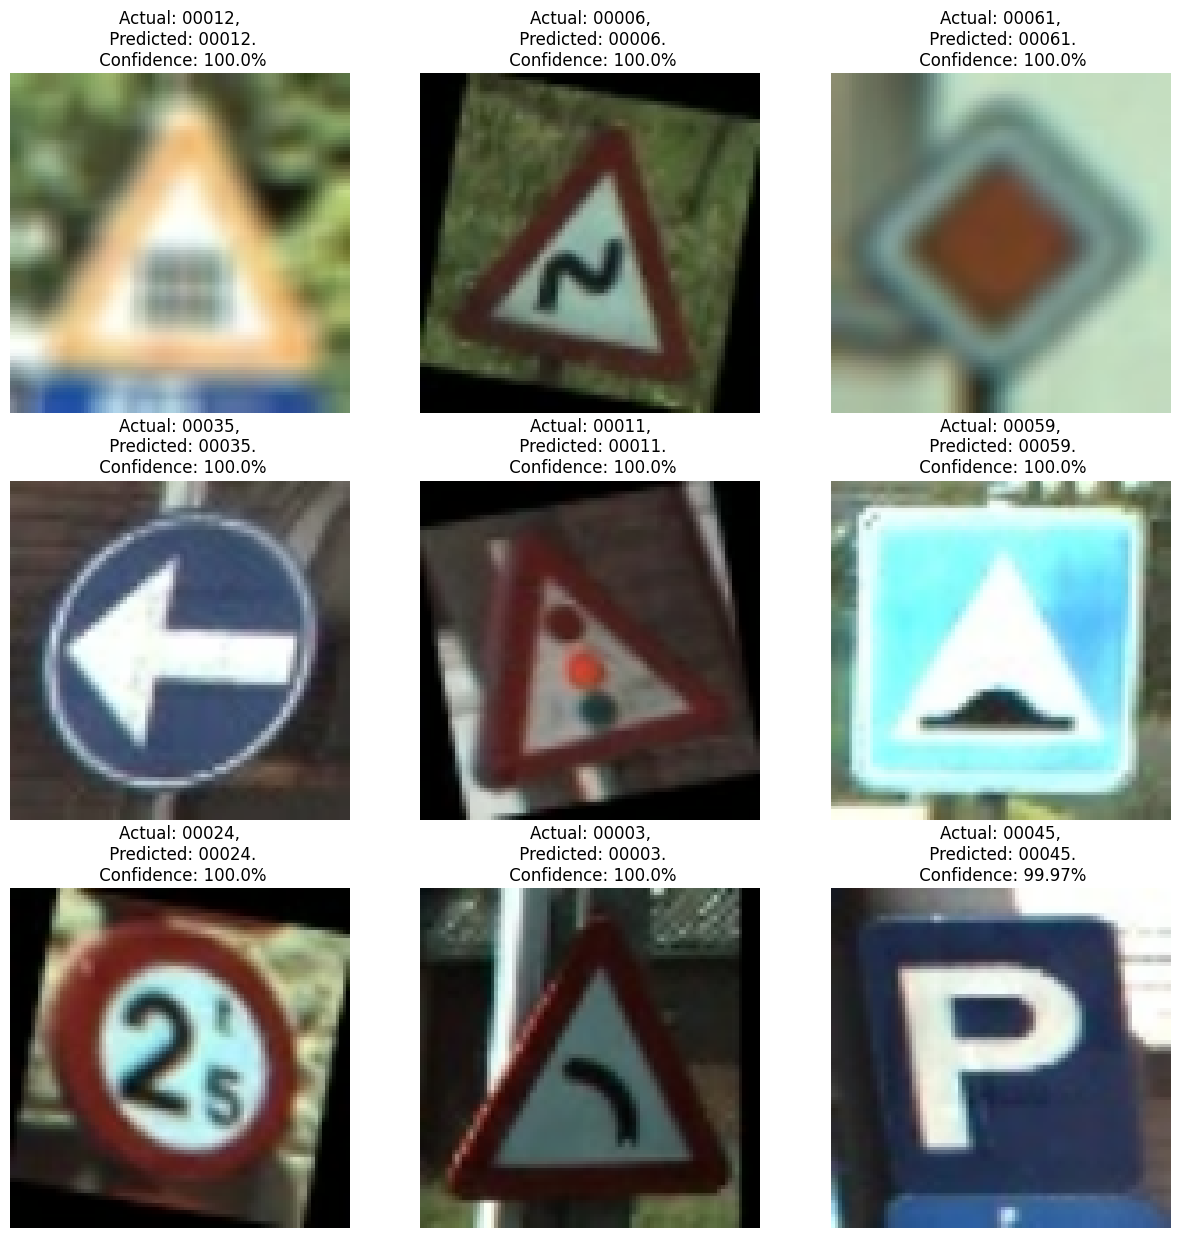

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in validation_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(modelF, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

1/1 [==============================] - 0s 37ms/step


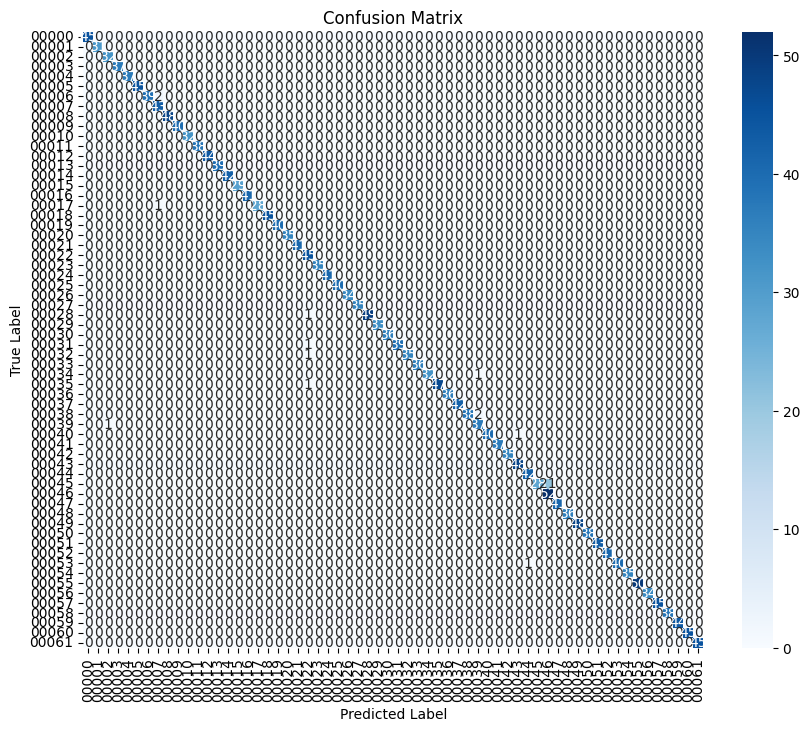

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
validation_dataset = validation_dataset.unbatch().batch(1)  # Batch size = 1 for individual predictions

# Replace 'Class 0' and 'Class 1' with the actual class names from your dataset

# Create empty arrays to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the validation dataset to obtain true and predicted labels
for images, labels in validation_dataset:
    predictions = model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))
    true_labels.extend(labels.numpy())

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)

# Add a title and axis labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()

1/1 [==============================] - 0s 37ms/step
F1 Score: 0.9877200016166935
Precision: 0.9905888986328368
Recall: 0.9877283049404888
ROC-AUC Score: 0.9999880569937513


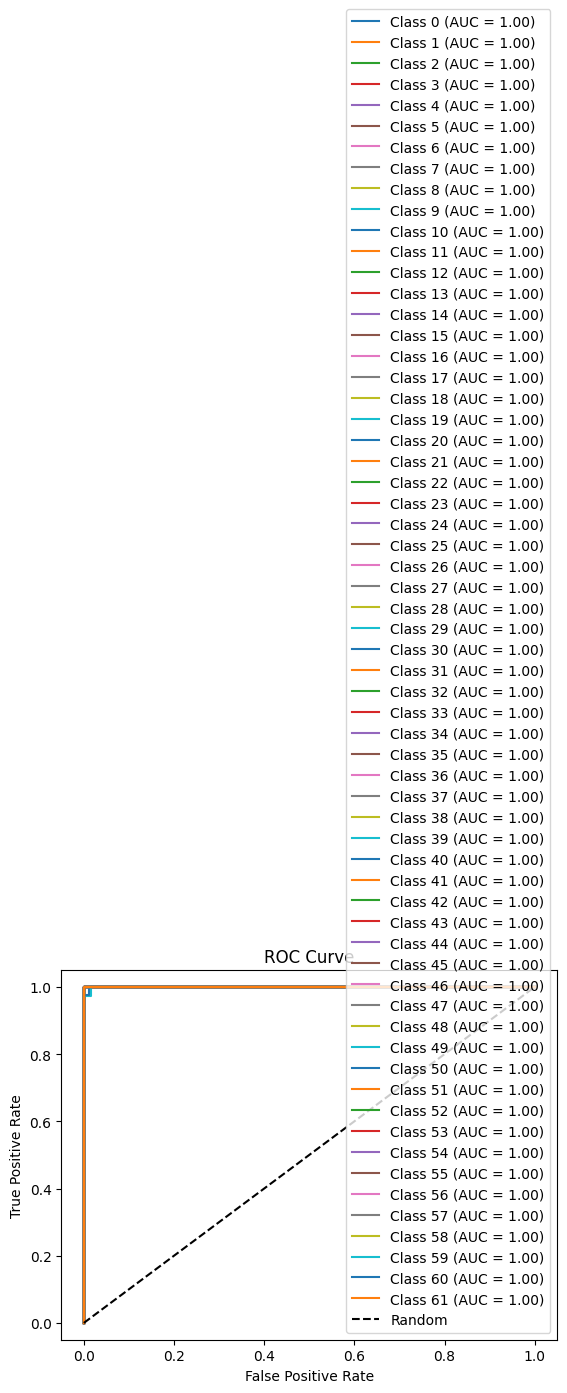

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt


# After model.fit(...)
validation_dataset = validation_dataset.unbatch().batch(1)  # Batch size = 1 for individual predictions

y_true = []
y_pred = []

for x_val, y_val in validation_dataset:
    y_true.append(y_val.numpy()[0])  # Append true labels
    y_pred.append(model.predict(x_val)[0])  # Append predicted probabilities (raw output)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate the metrics
f1 = f1_score(y_true, y_pred_classes, average='macro')
precision = precision_score(y_true, y_pred_classes, average='macro')
recall = recall_score(y_true, y_pred_classes, average='macro')
roc_auc = roc_auc_score(y_true, y_pred, multi_class='ovo')

print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"ROC-AUC Score: {roc_auc}")

# Plot ROC curves (only for binary classification or when using one-hot encoded labels)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(nb_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(nb_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


1/1 [==============================] - 0s 35ms/step
F1 Score: 0.9877200016166935
Precision: 0.9905888986328368
Recall: 0.9877283049404888
ROC-AUC Score: 0.9999880569937513


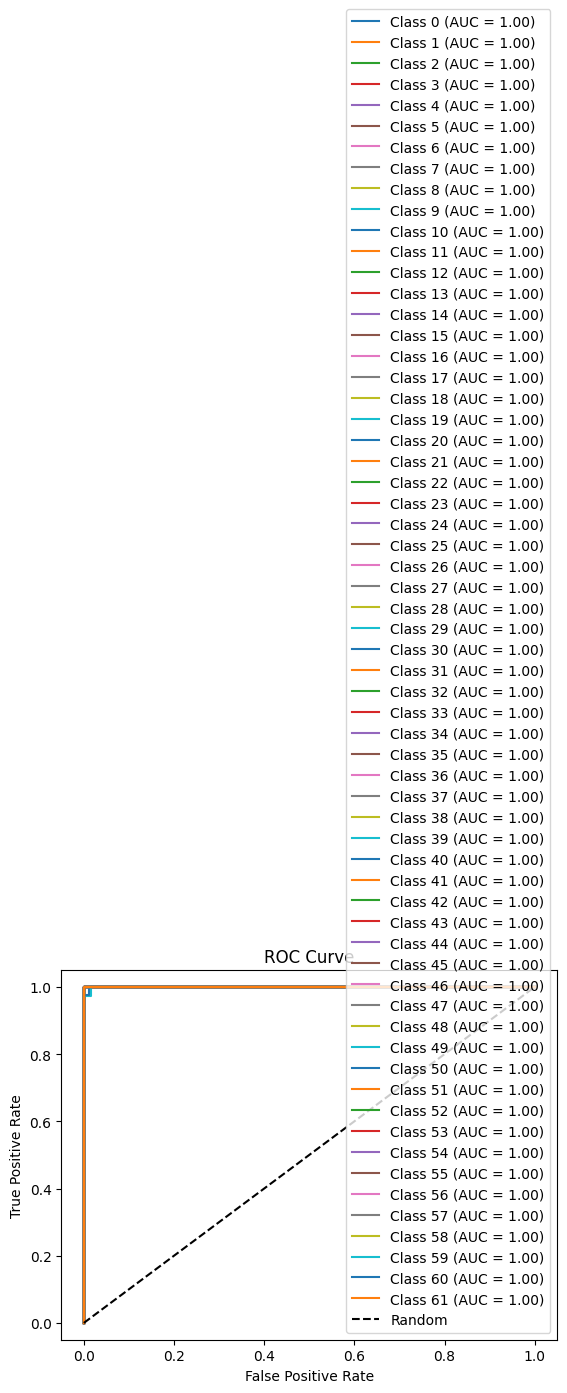

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt


# After model.fit(...)
validation_dataset = validation_dataset.unbatch().batch(1)  # Batch size = 1 for individual predictions

y_true = []
y_pred = []

for x_val, y_val in validation_dataset:
    y_true.append(y_val.numpy()[0])  # Append true labels
    y_pred.append(modelF.predict(x_val)[0])  # Append predicted probabilities (raw output)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate the metrics
f1 = f1_score(y_true, y_pred_classes, average='macro')
precision = precision_score(y_true, y_pred_classes, average='macro')
recall = recall_score(y_true, y_pred_classes, average='macro')
roc_auc = roc_auc_score(y_true, y_pred, multi_class='ovo')

print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"ROC-AUC Score: {roc_auc}")

# Plot ROC curves (only for binary classification or when using one-hot encoded labels)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(nb_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(nb_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


1/1 [==============================] - 0s 38ms/step
F1 Score: 0.8809835770601869
Precision: 0.8901506934393105
Recall: 0.9153270063856513
ROC-AUC Score: 0.9991400432625


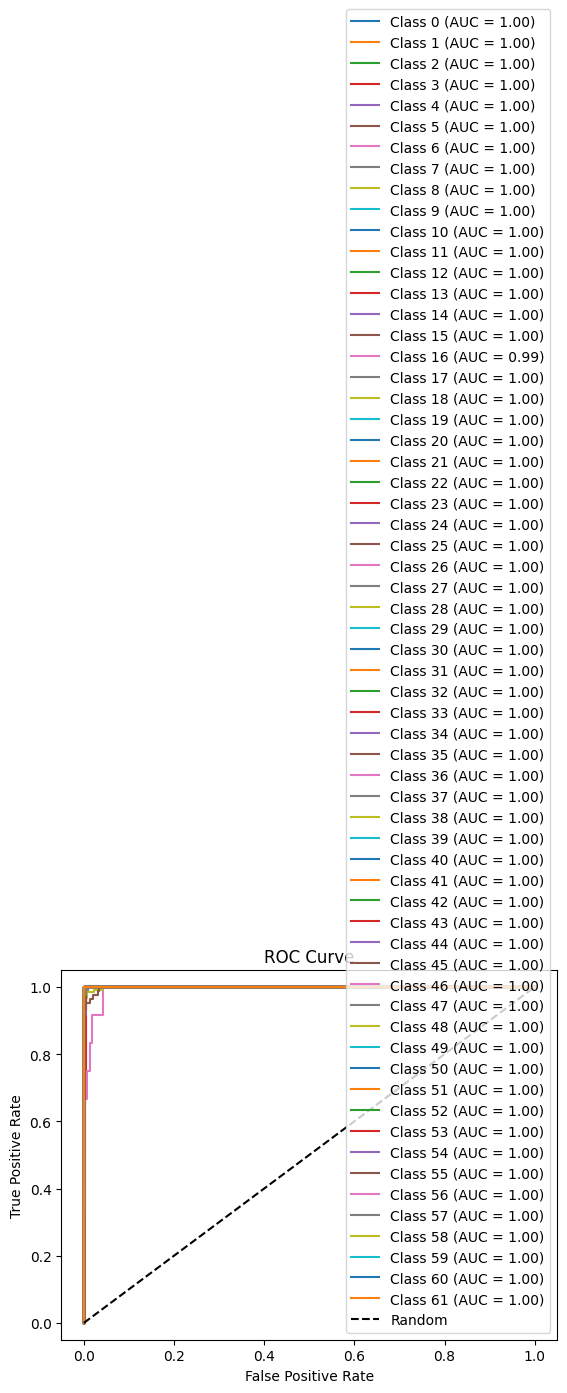

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt


# After model.fit(...)
test_dataset = test_dataset.unbatch().batch(1)  # Batch size = 1 for individual predictions

y_true = []
y_pred = []

for x_val, y_val in test_dataset:
    y_true.append(y_val.numpy()[0])  # Append true labels
    y_pred.append(model.predict(x_val)[0])  # Append predicted probabilities (raw output)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate the metrics
f1 = f1_score(y_true, y_pred_classes, average='macro')
precision = precision_score(y_true, y_pred_classes, average='macro')
recall = recall_score(y_true, y_pred_classes, average='macro')
roc_auc = roc_auc_score(y_true, y_pred, multi_class='ovo')

print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"ROC-AUC Score: {roc_auc}")

# Plot ROC curves (only for binary classification or when using one-hot encoded labels)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(nb_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(nb_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


1/1 [==============================] - 0s 37ms/step
F1 Score: 0.8809835770601869
Precision: 0.8901506934393105
Recall: 0.9153270063856513
ROC-AUC Score: 0.9991400432625


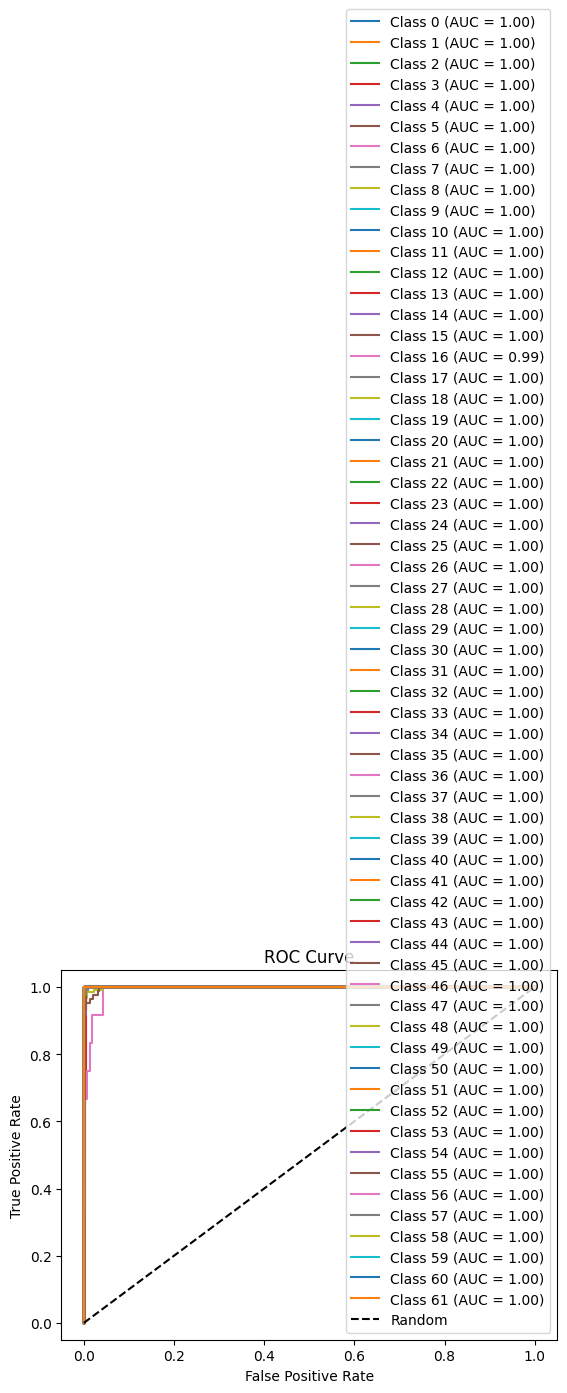

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt


# After model.fit(...)
test_dataset = test_dataset.unbatch().batch(1)  # Batch size = 1 for individual predictions

y_true = []
y_pred = []

for x_val, y_val in test_dataset:
    y_true.append(y_val.numpy()[0])  # Append true labels
    y_pred.append(modelF.predict(x_val)[0])  # Append predicted probabilities (raw output)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate the metrics
f1 = f1_score(y_true, y_pred_classes, average='macro')
precision = precision_score(y_true, y_pred_classes, average='macro')
recall = recall_score(y_true, y_pred_classes, average='macro')
roc_auc = roc_auc_score(y_true, y_pred, multi_class='ovo')

print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"ROC-AUC Score: {roc_auc}")

# Plot ROC curves (only for binary classification or when using one-hot encoded labels)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(nb_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(nb_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()